In [1]:
#importing the libraries required for the evaluation
import numpy as np
import rasterio
from pygeotools.lib import malib, warplib, iolib,geolib, timelib
import numpy.ma as ma
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
from imview.lib import pltlib
from osgeo import gdal, ogr

#### Import shapefiles first

In [2]:
glac_shp_fn='mummy.shp'
#ogr2ogr -f "ESRI Shapefile" 15_rgi50_SouthAsiaEast.shp  -t_srs EPSG:32645 in Bash Commandline to change projection of vectors
glac_shp_ds = ogr.Open(glac_shp_fn, 0) #shapefile_dataset
glac_shp_lyr = glac_shp_ds.GetLayer() #layer of shapefile, all the operations are performed on it....
glac_shp_srs = glac_shp_lyr.GetSpatialRef() #Spatial_reference_of_shapefile
feat_count = glac_shp_lyr.GetFeatureCount() #Feature_Count
print("Input glacier polygon count: %i" % feat_count)
print str(glac_shp_srs)

Input glacier polygon count: 13119
PROJCS["WGS_1984_UTM_Zone_45N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137,298.257223563]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.017453292519943295],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",87],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["Meter",1],
    AUTHORITY["EPSG","32645"]]


#### Input the dem and dh/dt map, define the extent of shapefiles only with the intersecting raster maps... to limit the polygons...

In [12]:
dh_dt='WV_Carto_RateMaps-tile-0-last.tif' #input elevation_difference_map
z='B-tile-0.tif' #input DEM
dh_dt_ds=gdal.Open(dh_dt) 
z_ds=gdal.Open(z)
dz_int_geom = geolib.ds_geom_intersection([dh_dt_ds, z_ds], t_srs=glac_shp_srs) #intersecting_extent
glac_shp_lyr.SetSpatialFilter(dz_int_geom) #spatial filtering of shapefiles within extent
feat_count = glac_shp_lyr.GetFeatureCount() #now only the polygons within the extents are considered
print("Filtered glacier polygon count: %i" % feat_count)
glac_shp_lyr.ResetReading()

Filtered glacier polygon count: 1072


In [13]:
glacname_fieldname = "Name"
glacnum_fieldname = "RGIId"

r={'Elevation_rounded', 'Area', 'mean', 'Elevation_normalised', 'RGI_Id'}
df=pd.DataFrame(columns=['Elevation_rounded', 'Area', 'mean', 'Elevation_normalised', 'RGI_Id'])
df.s

In [14]:
#Approach inspired from David's mb.py script
#Create polygon for valid pixels in DEM mosaics
#Intersect with each glacier polygon, only preserve those with 80% overlap
#Go through shp, extract feat name/number and geom
min_glac_area = 0.1
i=0
for n, feat in enumerate(glac_shp_lyr):
    print'Hi' #Check to see program flow...
    glacname = feat.GetField(glacname_fieldname)
    #Extracting glacier id/name from input shapefiles
    if glacname is None:
        glacname = ""
    glacnum = feat.GetField(glacnum_fieldname)
    #RGIId (String) = RGI50-01.00004
    #glacnum = float(glacnum.split('-')[-1])*10000000
    glacnum = float(glacnum.split('-')[-1])
    glacnum_fmt = '%0.5f'
    if glacname:
        feat_fn = "%s_%s" % (glacnum, glacname)
    else:
        feat_fn = str(glacnum)
    print("\n%i of %i: %s\n" % (n+1, feat_count, feat_fn))
    #extracting feature geometry, area, if less than 0.1sq.km., ignoring it
    glac_geom = feat.GetGeometryRef()
    glac_geom.AssignSpatialReference(glac_shp_srs)
    glac_geom_extent = geolib.geom_extent(glac_geom)
    glac_area = glac_geom.GetArea()
    print str(glac_area)
    if (glac_area/1E6) < min_glac_area:
        print("Glacier area below %0.1f km2 threshold" % min_glac_area)
        continue
    #warping the dh_dt and elevation map into common extents
    ds_list = warplib.memwarp_multi_fn([dh_dt, z], res='max',r='average',
            extent=glac_geom_extent, t_srs='EPSG:32645', verbose=False)
    #Defining mask based on geometry of current feature in loop
    glac_geom_mask = geolib.geom2mask(glac_geom, ds_list[0])
    dh_dt_a = ma.array(iolib.ds_getma(ds_list[0]), mask=glac_geom_mask)
    z_a = ma.array(iolib.ds_getma(ds_list[1]), mask=glac_geom_mask) 
    #80 percent_area_quantification
    ds_res = geolib.get_res(ds_list[0])
    valid_area = dh_dt_a.count()*ds_res[0]*ds_res[1]
    valid_area_perc = valid_area/glac_area
    min_valid_area_perc = 0.80
    print'Ho' #Check to see program flow...
    if valid_area_perc < min_valid_area_perc:
        print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (100*valid_area_perc))
        continue
    #preparing dataframes for qualifying glaciers
    common_mask=malib.common_mask([dh_dt_a,z_a]) #common mask based on DEM and dh_dt as there might be some DEM pixels for no dh/dt pixel
    dh_dt_f=ma.compressed(ma.array(dh_dt_a,mask=common_mask))
    z_f=ma.compressed(ma.array(z_a,mask=common_mask))
    raw={'Elevation':z_f,
    feat_fn:dh_dt_f} #feat_fn saves the rgi id or name of the glacier
    print'Hola' #Check to see program flow...
    df1=pd.DataFrame(raw, columns=['Elevation',feat_fn])
    #Sorting the obtained dataframes based on asscending elevation
    df1=df1.sort_values(by='Elevation',ascending=True)
    #Rounding Glacier Elevation to next nearest multiple of 50
    df1['Elevation_rounded']=(df1['Elevation']+49)//50*50
    #Calulating_stats_for_Glacier_Pixels
    grouped=df1.groupby('Elevation_rounded')
    df2=grouped[feat_fn].agg([np.mean,np.count_nonzero,np.median])
    #Creating a coulumn identical to the indexed "Elevation rouded" so that it can be used for manipulation
    df2['E1'] = df2.index
    #znorm= (z - zmin) /(zmax-zmin) #Larsen et al. 2015, GRL
    #DataFrame.max(axis=None, skipna=None, level=None, numeric_only=None, **kwargs) #Syntax
    Max_limit=df2['E1'].max()
    print Max_limit
    Min_limit=df2['E1'].min()
    print Min_limit
    deno=Max_limit-Min_limit
    df2['Elevation_normalised']=(df2['E1']-Min_limit)/deno
    df2['Area']=df2['count_nonzero']*ds_res[0]*ds_res[1]
    df3=df2[['Area', 'mean', 'Elevation_normalised','median']].copy()
    df3['RGI_Id']=feat_fn
    if i==0:
        df = df3
    else:
        df = df.append(df3)
    i=i+1


Hi

1 of 1072: 15.02697

526041.931846

Warping all inputs to the following:
Resolution: 10.0
Extent: [615955.0087304136, 3085337.401336626, 617211.4534322533, 3085943.840496815]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 61 ns: 126 res: 10.000
2 of 2: B-tile-0.tif
nl: 61 ns: 126 res: 10.000
Ho
Hola
5800.0
5550.0
Hi

2 of 1072: 15.02698

11704364.2729

Warping all inputs to the following:
Resolution: 10.0
Extent: [611049.993403404, 3084082.156530921, 617563.6785395433, 3088393.8870531027]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 431 ns: 651 res: 10.000
2 of 2: B-tile-0.tif
nl: 431 ns: 651 res: 10.000
Ho
Hola
7450.0
5200.0
Hi

3 of 1072: 15.02699

3009359.61128

Warping all inputs to the following:
Resolution: 10.0
Extent: [609987.3776952798, 3082838.6865264266, 612237.2224962701, 3084719.877870378]
Pr

2 of 2: B-tile-0.tif
nl: 181 ns: 158 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi

29 of 1072: 15.02725

114489.043732

Warping all inputs to the following:
Resolution: 10.0
Extent: [605387.6771417009, 3046816.5957449283, 605830.6931298929, 3047304.129839508]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 49 ns: 44 res: 10.000
2 of 2: B-tile-0.tif
nl: 49 ns: 44 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi

30 of 1072: 15.02726

119782.094543

Warping all inputs to the following:
Resolution: 10.0
Extent: [604045.6944284941, 3046171.4528893665, 604597.5162961292, 3046563.1008623894]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 39 ns: 55 res: 10.000
2 of 2: B-tile-0.tif
nl: 39 ns: 55 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glac

Ho
Hola
6100.0
4900.0
Hi

49 of 1072: 15.02745

576306.836414

Warping all inputs to the following:
Resolution: 10.0
Extent: [620799.8401256073, 3046135.650003121, 621833.0731343811, 3047037.8986684624]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 90 ns: 103 res: 10.000
2 of 2: B-tile-0.tif
nl: 90 ns: 103 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi

50 of 1072: 15.02746

417802.004823

Warping all inputs to the following:
Resolution: 10.0
Extent: [619273.0632235546, 3047000.049804999, 620221.613311182, 3047946.5182900233]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 95 ns: 95 res: 10.000
2 of 2: B-tile-0.tif
nl: 95 ns: 95 res: 10.000
Ho
Hola
5450.0
4950.0
Hi

51 of 1072: 15.02747

231552.878823

Warping all inputs to the following:
Resolution: 10.0
Extent: [621699.7228306

2 of 2: B-tile-0.tif
nl: 187 ns: 100 res: 10.000
Ho
Hola
5650.0
4900.0
Hi

71 of 1072: 15.02767

311271.708171

Warping all inputs to the following:
Resolution: 10.0
Extent: [598745.2472950852, 3054154.4118474834, 599625.1180599733, 3055495.2843696047]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 134 ns: 88 res: 10.000
2 of 2: B-tile-0.tif
nl: 134 ns: 88 res: 10.000
Ho
Hola
5900.0
4950.0
Hi

72 of 1072: 15.02768

87176.9754991
Glacier area below 0.1 km2 threshold
Hi

73 of 1072: 15.02769

207872.989185

Warping all inputs to the following:
Resolution: 10.0
Extent: [599495.9466685798, 3057065.0197355766, 600494.1619601862, 3057707.2294417117]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 64 ns: 100 res: 10.000
2 of 2: B-tile-0.tif
nl: 64 ns: 100 res: 10.000
Ho
Hola
5600.0
4950.0
Hi

74 of 1072: 15.0277

58151

2 of 2: B-tile-0.tif
nl: 590 ns: 674 res: 10.000
Ho
Hola
7450.0
4750.0
Hi

94 of 1072: 15.0279

1918262.62717

Warping all inputs to the following:
Resolution: 10.0
Extent: [608892.639421468, 3065268.0994845256, 611436.4782392369, 3066613.3159740716]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 135 ns: 254 res: 10.000
2 of 2: B-tile-0.tif
nl: 135 ns: 254 res: 10.000
Ho
Not enough valid pixels. 69.4% percent of glacier polygon area
Hi

95 of 1072: 15.02791

785879.464638

Warping all inputs to the following:
Resolution: 10.0
Extent: [608967.3737073194, 3067022.4379872708, 610029.5816026314, 3068080.215069805]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 106 ns: 106 res: 10.000
2 of 2: B-tile-0.tif
nl: 106 ns: 106 res: 10.000
Ho
Not enough valid pixels. 79.9% percent of glacier polygon area
Hi

96 of 1072: 15

Ho
Hola
6000.0
5700.0
Hi

114 of 1072: 15.0281

932096.530802

Warping all inputs to the following:
Resolution: 10.0
Extent: [625587.6317782574, 3076121.771621661, 626480.012889707, 3077652.3865217394]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 153 ns: 89 res: 10.000
2 of 2: B-tile-0.tif
nl: 153 ns: 89 res: 10.000
Ho
Hola
6000.0
5650.0
Hi

115 of 1072: 15.02811

209066.377537

Warping all inputs to the following:
Resolution: 10.0
Extent: [627236.5930241521, 3076811.224105765, 627702.3903484923, 3077580.239974732]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 77 ns: 47 res: 10.000
2 of 2: B-tile-0.tif
nl: 77 ns: 47 res: 10.000
Ho
Hola
5850.0
5700.0
Hi

116 of 1072: 15.02812

626890.216474

Warping all inputs to the following:
Resolution: 10.0
Extent: [626289.9993236681, 3076328.728028746, 627335.4420181909,

2 of 2: B-tile-0.tif
nl: 508 ns: 678 res: 10.000
Ho
Hola
6500.0
3850.0
Hi

136 of 1072: 15.02832

446992.074954

Warping all inputs to the following:
Resolution: 10.0
Extent: [618433.4809290791, 3057840.3590585175, 619334.603424648, 3058809.488497274]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 97 ns: 90 res: 10.000
2 of 2: B-tile-0.tif
nl: 97 ns: 90 res: 10.000
Ho
Not enough valid pixels. 10.7% percent of glacier polygon area
Hi

137 of 1072: 15.02833

5569960.55422

Warping all inputs to the following:
Resolution: 10.0
Extent: [616697.8696776625, 3057159.1276670387, 621940.2416811395, 3061648.292570832]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 449 ns: 524 res: 10.000
2 of 2: B-tile-0.tif
nl: 449 ns: 524 res: 10.000
Ho
Not enough valid pixels. 71.9% percent of glacier polygon area
Hi

138 of 1072: 15.

2 of 2: B-tile-0.tif
nl: 68 ns: 147 res: 10.000
Ho
Hola
6600.0
5500.0
Hi

158 of 1072: 15.02854

505742.193866

Warping all inputs to the following:
Resolution: 10.0
Extent: [615497.7243035965, 3077287.1886038724, 616429.0280686192, 3078178.250777472]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 89 ns: 93 res: 10.000
2 of 2: B-tile-0.tif
nl: 89 ns: 93 res: 10.000
Ho
Hola
7150.0
6500.0
Hi

159 of 1072: 15.02855

498278.902081

Warping all inputs to the following:
Resolution: 10.0
Extent: [609286.6766403168, 3079914.2222091346, 610085.7199076083, 3081342.975040995]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 143 ns: 80 res: 10.000
2 of 2: B-tile-0.tif
nl: 143 ns: 80 res: 10.000
Ho
Hola
6200.0
5900.0
Hi

160 of 1072: 15.02856

8911275.45291

Warping all inputs to the following:
Resolution: 10.0
Extent: [60306

2 of 2: B-tile-0.tif
nl: 69 ns: 72 res: 10.000
Ho
Hola
6350.0
5850.0
Hi

181 of 1072: 15.02877

799507.066379

Warping all inputs to the following:
Resolution: 10.0
Extent: [599224.7116183878, 3084722.0171824005, 600683.4906936917, 3086321.87389419]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 160 ns: 146 res: 10.000
2 of 2: B-tile-0.tif
nl: 160 ns: 146 res: 10.000
Ho
Hola
6500.0
5550.0
Hi

182 of 1072: 15.02878

157045.708186

Warping all inputs to the following:
Resolution: 10.0
Extent: [595040.6852938725, 3082786.549491889, 595642.9212181128, 3083342.2982993345]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 56 ns: 60 res: 10.000
2 of 2: B-tile-0.tif
nl: 56 ns: 60 res: 10.000
Ho
Hola
5950.0
5650.0
Hi

183 of 1072: 15.02879

3165130.54551

Warping all inputs to the following:
Resolution: 10.0
Extent: [59413

2 of 2: B-tile-0.tif
nl: 88 ns: 74 res: 10.000
Ho
Hola
5550.0
5200.0
Hi

207 of 1072: 15.02903

174385.114135

Warping all inputs to the following:
Resolution: 10.0
Extent: [586902.2979695317, 3083057.1344435792, 587484.9916351265, 3083548.6557659646]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 49 ns: 58 res: 10.000
2 of 2: B-tile-0.tif
nl: 49 ns: 58 res: 10.000
Ho
Hola
5700.0
5450.0
Hi

208 of 1072: 15.02904

532010.292344

Warping all inputs to the following:
Resolution: 10.0
Extent: [587838.9013439997, 3084479.2408579946, 588801.6347579017, 3085709.8298958847]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 123 ns: 96 res: 10.000
2 of 2: B-tile-0.tif
nl: 123 ns: 96 res: 10.000
Ho
Hola
6000.0
5350.0
Hi

209 of 1072: 15.02905

471683.375326

Warping all inputs to the following:
Resolution: 10.0
Extent: [5854

Ho
Hola
5700.0
5100.0
Hi

232 of 1072: 15.02928

52762.0339079
Glacier area below 0.1 km2 threshold
Hi

233 of 1072: 15.02929

158789.116907

Warping all inputs to the following:
Resolution: 10.0
Extent: [660466.068313212, 3094749.028163423, 660942.8723617003, 3095241.1541865207]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 49 ns: 48 res: 10.000
2 of 2: B-tile-0.tif
nl: 49 ns: 48 res: 10.000
Ho
Hola
5350.0
5100.0
Hi

234 of 1072: 15.0293

925057.375168

Warping all inputs to the following:
Resolution: 10.0
Extent: [660027.4121715699, 3094992.445355677, 661512.3477704194, 3096172.9970601727]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 118 ns: 148 res: 10.000
2 of 2: B-tile-0.tif
nl: 118 ns: 148 res: 10.000
Ho
Not enough valid pixels. 65.9% percent of glacier polygon area
Hi

235 of 1072: 15.02931

508596.12

6100.0
5350.0
Hi

260 of 1072: 15.02956

1406481.38393

Warping all inputs to the following:
Resolution: 10.0
Extent: [667639.1087813013, 3095698.189721807, 668671.9577124867, 3098182.978303836]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 248 ns: 103 res: 10.000
2 of 2: B-tile-0.tif
nl: 248 ns: 103 res: 10.000
Ho
Hola
6050.0
5250.0
Hi

261 of 1072: 15.02957

413448.604621

Warping all inputs to the following:
Resolution: 10.0
Extent: [669496.683514535, 3096473.1716335015, 670488.5748162668, 3097042.301650507]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 57 ns: 99 res: 10.000
2 of 2: B-tile-0.tif
nl: 57 ns: 99 res: 10.000
Ho
Hola
5650.0
5350.0
Hi

262 of 1072: 15.02958

318136.01742

Warping all inputs to the following:
Resolution: 10.0
Extent: [664708.4477005858, 3098325.3725830815, 665538.3128919736, 3099

Ho
Hola
5900.0
5150.0
Hi

283 of 1072: 15.02979

360551.668249

Warping all inputs to the following:
Resolution: 10.0
Extent: [662067.6158183366, 3085088.1658705897, 663271.3384918326, 3085660.1286671124]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 57 ns: 120 res: 10.000
2 of 2: B-tile-0.tif
nl: 57 ns: 120 res: 10.000
Ho
Hola
5650.0
5150.0
Hi

284 of 1072: 15.0298

1996733.30901

Warping all inputs to the following:
Resolution: 10.0
Extent: [659721.8609792724, 3084485.7147643263, 661525.1441155074, 3087320.705689702]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 283 ns: 180 res: 10.000
2 of 2: B-tile-0.tif
nl: 283 ns: 180 res: 10.000
Ho
Hola
5800.0
5100.0
Hi

285 of 1072: 15.02981

661237.598701

Warping all inputs to the following:
Resolution: 10.0
Extent: [659912.5272670579, 3084469.011809368, 660584.5702

2 of 2: B-tile-0.tif
nl: 54 ns: 70 res: 10.000
Ho
Not enough valid pixels. 0.1% percent of glacier polygon area
Hi

310 of 1072: 15.03006

67573.9751044
Glacier area below 0.1 km2 threshold
Hi

311 of 1072: 15.03007

73662.1593963
Glacier area below 0.1 km2 threshold
Hi

312 of 1072: 15.03008

487881.895413

Warping all inputs to the following:
Resolution: 10.0
Extent: [629287.2587454161, 3068565.3441113555, 630477.8861389804, 3069316.0212886925]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 75 ns: 119 res: 10.000
2 of 2: B-tile-0.tif
nl: 75 ns: 119 res: 10.000
Ho
Hola
5300.0
5050.0
Hi

313 of 1072: 15.03009

499939.384982

Warping all inputs to the following:
Resolution: 10.0
Extent: [626518.0715030102, 3068609.3117272393, 627216.5492771151, 3069743.2601546156]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 1

Ho
Hola
6450.0
4650.0
Hi

335 of 1072: 15.03031

58173.8451667
Glacier area below 0.1 km2 threshold
Hi

336 of 1072: 15.03032

247970.363295

Warping all inputs to the following:
Resolution: 10.0
Extent: [675506.3263103592, 3090193.9497954864, 675998.4522832191, 3091093.5349747995]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 90 ns: 49 res: 10.000
2 of 2: B-tile-0.tif
nl: 90 ns: 49 res: 10.000
Ho
Hola
5750.0
5350.0
Hi

337 of 1072: 15.03033

355340.839614

Warping all inputs to the following:
Resolution: 10.0
Extent: [674421.9739870573, 3089733.934407629, 675691.976568051, 3090345.1231081155]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 61 ns: 127 res: 10.000
2 of 2: B-tile-0.tif
nl: 61 ns: 127 res: 10.000
Ho
Hola
5700.0
5300.0
Hi

338 of 1072: 15.03034

687202.083231

Warping all inputs to the following:
R

5150.0
Hi

360 of 1072: 15.03056

1659582.93678

Warping all inputs to the following:
Resolution: 10.0
Extent: [683426.0663481419, 3083903.206996473, 685225.4371195452, 3085826.0358799337]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 192 ns: 180 res: 10.000
2 of 2: B-tile-0.tif
nl: 192 ns: 180 res: 10.000
Ho
Hola
6450.0
4800.0
Hi

361 of 1072: 15.03057

319874.483337

Warping all inputs to the following:
Resolution: 10.0
Extent: [683975.564649074, 3083675.9890470905, 684751.8806075185, 3084489.3865906657]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 81 ns: 78 res: 10.000
2 of 2: B-tile-0.tif
nl: 81 ns: 78 res: 10.000
Ho
Hola
5500.0
5050.0
Hi

362 of 1072: 15.03058

310014.843792

Warping all inputs to the following:
Resolution: 10.0
Extent: [684149.6907688827, 3083066.100548096, 685229.0370704666, 3083605.4

Ho
Hola
5950.0
5100.0
Hi

392 of 1072: 15.03088

1479599.57174

Warping all inputs to the following:
Resolution: 10.0
Extent: [595242.2808703479, 3075197.8412602516, 596657.5888064514, 3077429.490214202]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 223 ns: 142 res: 10.000
2 of 2: B-tile-0.tif
nl: 223 ns: 142 res: 10.000
Ho
Hola
6250.0
5200.0
Hi

393 of 1072: 15.03089

274194.113011

Warping all inputs to the following:
Resolution: 10.0
Extent: [594087.504632286, 3077336.578409482, 594552.0802969448, 3078442.0824280055]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 111 ns: 46 res: 10.000
2 of 2: B-tile-0.tif
nl: 111 ns: 46 res: 10.000
Ho
Hola
5650.0
5200.0
Hi

394 of 1072: 15.0309

935412.065128

Warping all inputs to the following:
Resolution: 10.0
Extent: [595040.6852770901, 3078568.707051502, 597050.607427

2 of 2: B-tile-0.tif
nl: 155 ns: 136 res: 10.000
Ho
Hola
6000.0
5300.0
Hi

414 of 1072: 15.0311

190203.317539

Warping all inputs to the following:
Resolution: 10.0
Extent: [590752.814960867, 3070866.092947817, 591450.7490981576, 3071280.980022558]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 41 ns: 70 res: 10.000
2 of 2: B-tile-0.tif
nl: 41 ns: 70 res: 10.000
Ho
Hola
5900.0
5600.0
Hi

415 of 1072: 15.03111

591062.362943

Warping all inputs to the following:
Resolution: 10.0
Extent: [590752.2476709352, 3071102.5165344165, 592392.66759849, 3072062.012005273]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 96 ns: 164 res: 10.000
2 of 2: B-tile-0.tif
nl: 96 ns: 164 res: 10.000
Ho
Hola
5900.0
5000.0
Hi

416 of 1072: 15.03112

261121.7705

Warping all inputs to the following:
Resolution: 10.0
Extent: [591109.0677

2 of 2: B-tile-0.tif
nl: 63 ns: 95 res: 10.000
Ho
Hola
5850.0
5400.0
Hi

441 of 1072: 15.03137

240360.857431

Warping all inputs to the following:
Resolution: 10.0
Extent: [589593.370418907, 3062766.0713291434, 590332.8915215924, 3063378.3173502753]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 61 ns: 74 res: 10.000
2 of 2: B-tile-0.tif
nl: 61 ns: 74 res: 10.000
Ho
Hola
5700.0
5200.0
Hi

442 of 1072: 15.03138

507788.713861

Warping all inputs to the following:
Resolution: 10.0
Extent: [589981.9047112231, 3062759.2433174797, 591260.2487195486, 3063856.903948913]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 110 ns: 128 res: 10.000
2 of 2: B-tile-0.tif
nl: 110 ns: 128 res: 10.000
Ho
Hola
5750.0
5050.0
Hi

443 of 1072: 15.03139

617967.460806

Warping all inputs to the following:
Resolution: 10.0
Extent: [5888

Ho
Hola
5700.0
5150.0
Hi

469 of 1072: 15.03165

120979.07554

Warping all inputs to the following:
Resolution: 10.0
Extent: [597328.0596472177, 3059044.758661411, 597891.0469645215, 3059473.765124872]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 43 ns: 56 res: 10.000
2 of 2: B-tile-0.tif
nl: 43 ns: 56 res: 10.000
Ho
Hola
5550.0
5100.0
Hi

470 of 1072: 15.03166

669887.124212

Warping all inputs to the following:
Resolution: 10.0
Extent: [597767.8419983841, 3058791.138675542, 598642.4650847615, 3060428.779482526]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 164 ns: 87 res: 10.000
2 of 2: B-tile-0.tif
nl: 164 ns: 87 res: 10.000
Ho
Hola
5750.0
5100.0
Hi

471 of 1072: 15.03167

350989.151853

Warping all inputs to the following:
Resolution: 10.0
Extent: [604091.324741789, 3051505.675020042, 606266.2041761914, 

2 of 2: B-tile-0.tif
nl: 482 ns: 644 res: 10.000
Ho
Not enough valid pixels. 52.2% percent of glacier polygon area
Hi

493 of 1072: 15.03189

1568503.45326

Warping all inputs to the following:
Resolution: 10.0
Extent: [614560.7210406156, 3053572.772156115, 616730.3783950749, 3054785.343909341]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 121 ns: 217 res: 10.000
2 of 2: B-tile-0.tif
nl: 121 ns: 217 res: 10.000
Ho
Not enough valid pixels. 32.5% percent of glacier polygon area
Hi

494 of 1072: 15.0319

338410.266514

Warping all inputs to the following:
Resolution: 10.0
Extent: [613207.547788948, 3049334.9603718664, 614248.7726675025, 3050075.213480641]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 74 ns: 104 res: 10.000
2 of 2: B-tile-0.tif
nl: 74 ns: 104 res: 10.000
Ho
Not enough valid pixels. 8.4% percent o

2 of 2: B-tile-0.tif
nl: 110 ns: 369 res: 10.000
Ho
Not enough valid pixels. 64.7% percent of glacier polygon area
Hi

515 of 1072: 15.03211

1071053.46887

Warping all inputs to the following:
Resolution: 10.0
Extent: [623761.7359031449, 3061843.7724714885, 626316.1092670036, 3062858.709764821]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 101 ns: 255 res: 10.000
2 of 2: B-tile-0.tif
nl: 101 ns: 255 res: 10.000
Ho
Not enough valid pixels. 76.9% percent of glacier polygon area
Hi

516 of 1072: 15.03212

475569.611922

Warping all inputs to the following:
Resolution: 10.0
Extent: [623973.1942077128, 3061489.0695010126, 625360.699593712, 3062464.184994767]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 98 ns: 139 res: 10.000
2 of 2: B-tile-0.tif
nl: 98 ns: 139 res: 10.000
Ho
Hola
6200.0
5300.0
Hi

517 of 1072: 1

5850.0
5250.0
Hi

540 of 1072: 15.03236

538242.972291

Warping all inputs to the following:
Resolution: 10.0
Extent: [600581.4969301634, 3066644.2156615453, 601526.4291936631, 3067802.8652152615]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 116 ns: 94 res: 10.000
2 of 2: B-tile-0.tif
nl: 116 ns: 94 res: 10.000
Ho
Hola
5800.0
5300.0
Hi

541 of 1072: 15.03237

548803.58673

Warping all inputs to the following:
Resolution: 10.0
Extent: [600153.4035472912, 3067787.524617878, 601245.9703591364, 3069012.326167449]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 122 ns: 109 res: 10.000
2 of 2: B-tile-0.tif
nl: 122 ns: 109 res: 10.000
Ho
Hola
6150.0
5500.0
Hi

542 of 1072: 15.03238

70651.1856641
Glacier area below 0.1 km2 threshold
Hi

543 of 1072: 15.03239

1604357.05712

Warping all inputs to the following:
Resolu

Ho
Not enough valid pixels. 46.1% percent of glacier polygon area
Hi

564 of 1072: 15.0326

95565.3531076
Glacier area below 0.1 km2 threshold
Hi

565 of 1072: 15.03261

122406.45317

Warping all inputs to the following:
Resolution: 10.0
Extent: [663502.0797737992, 3083156.9909301223, 663850.8076609721, 3083685.879448527]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 53 ns: 35 res: 10.000
2 of 2: B-tile-0.tif
nl: 53 ns: 35 res: 10.000
Ho
Hola
5250.0
5000.0
Hi

566 of 1072: 15.03262

344159.904712

Warping all inputs to the following:
Resolution: 10.0
Extent: [662625.088929631, 3083116.962269232, 663317.2136130345, 3083799.962977781]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 68 ns: 69 res: 10.000
2 of 2: B-tile-0.tif
nl: 68 ns: 69 res: 10.000
Ho
Not enough valid pixels. 55.8% percent of glacier polygon are

2 of 2: B-tile-0.tif
nl: 40 ns: 64 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi

591 of 1072: 15.03287

536454.820258

Warping all inputs to the following:
Resolution: 10.0
Extent: [658166.2195511153, 3080216.0199631485, 659106.1465152181, 3081541.8555622064]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 133 ns: 94 res: 10.000
2 of 2: B-tile-0.tif
nl: 133 ns: 94 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi

592 of 1072: 15.03288

217101.193501

Warping all inputs to the following:
Resolution: 10.0
Extent: [667773.7842015474, 3068860.3098833268, 668187.6969538677, 3069623.461495796]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 76 ns: 41 res: 10.000
2 of 2: B-tile-0.tif
nl: 76 ns: 41 res: 10.000
Ho
Not enough valid pixels. 56.7% percent of g

Ho
Not enough valid pixels. 3.6% percent of glacier polygon area
Hi

615 of 1072: 15.03311

617956.358342

Warping all inputs to the following:
Resolution: 10.0
Extent: [632029.1430741028, 3061421.3082079403, 633282.3788886676, 3062444.592476422]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 102 ns: 125 res: 10.000
2 of 2: B-tile-0.tif
nl: 102 ns: 125 res: 10.000
Ho
Not enough valid pixels. 3.3% percent of glacier polygon area
Hi

616 of 1072: 15.03312

220020.838394

Warping all inputs to the following:
Resolution: 10.0
Extent: [632769.7110456397, 3074414.9100874006, 633356.0875221186, 3075070.272020276]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 66 ns: 59 res: 10.000
2 of 2: B-tile-0.tif
nl: 66 ns: 59 res: 10.000
Ho
Not enough valid pixels. 13.6% percent of glacier polygon area
Hi

617 of 1072: 15.03313


2 of 2: B-tile-0.tif
nl: 234 ns: 248 res: 10.000
Ho
Hola
5900.0
5050.0
Hi

640 of 1072: 15.03336

520311.481957

Warping all inputs to the following:
Resolution: 10.0
Extent: [675530.3010000996, 3088623.1051936015, 676846.1970140082, 3089984.5319470563]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 136 ns: 132 res: 10.000
2 of 2: B-tile-0.tif
nl: 136 ns: 132 res: 10.000
Ho
Hola
5700.0
5400.0
Hi

641 of 1072: 15.03337

5267186.43329

Warping all inputs to the following:
Resolution: 10.0
Extent: [676021.8224227744, 3087045.7548384736, 679579.6379262947, 3091719.5196107104]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 467 ns: 356 res: 10.000
2 of 2: B-tile-0.tif
nl: 467 ns: 356 res: 10.000
Ho
Hola
6500.0
5200.0
Hi

642 of 1072: 15.03338

442540.851833

Warping all inputs to the following:
Resolution: 10.0
Exten

2 of 2: B-tile-0.tif
nl: 284 ns: 165 res: 10.000
Ho
Hola
5650.0
4700.0
Hi

666 of 1072: 15.03362

98719.0502805
Glacier area below 0.1 km2 threshold
Hi

667 of 1072: 15.03363

359714.579968

Warping all inputs to the following:
Resolution: 10.0
Extent: [672028.7568848837, 3077906.788957508, 672689.4630386769, 3078812.9257463086]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 91 ns: 66 res: 10.000
2 of 2: B-tile-0.tif
nl: 91 ns: 66 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi

668 of 1072: 15.03364

268472.932371

Warping all inputs to the following:
Resolution: 10.0
Extent: [676033.5729949622, 3076823.2222348154, 677058.6537853598, 3077715.7215262214]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 89 ns: 103 res: 10.000
2 of 2: B-tile-0.tif
nl: 89 ns: 103 res: 10.000
Ho
Not en

2 of 2: B-tile-0.tif
nl: 132 ns: 64 res: 10.000
Ho
Hola
5550.0
5100.0
Hi

691 of 1072: 15.03645

222804.190132

Warping all inputs to the following:
Resolution: 10.0
Extent: [559814.4056029357, 3065681.846019614, 560391.5713149244, 3066448.442240511]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 77 ns: 58 res: 10.000
2 of 2: B-tile-0.tif
nl: 77 ns: 58 res: 10.000
Ho
Hola
5550.0
5200.0
Hi

692 of 1072: 15.03646

706643.999677

Warping all inputs to the following:
Resolution: 10.0
Extent: [560876.1521314007, 3065814.387834322, 561755.0942854513, 3067119.1458931104]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 130 ns: 88 res: 10.000
2 of 2: B-tile-0.tif
nl: 130 ns: 88 res: 10.000
Ho
Not enough valid pixels. 64.0% percent of glacier polygon area
Hi

693 of 1072: 15.03647

883806.760183

Warping all inputs to the

2 of 2: B-tile-0.tif
nl: 217 ns: 104 res: 10.000
Ho
Hola
5700.0
5100.0
Hi

717 of 1072: 15.03671

134065.255866

Warping all inputs to the following:
Resolution: 10.0
Extent: [579849.5422639704, 3076014.0856110444, 580334.8349735929, 3076499.181585731]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 49 ns: 49 res: 10.000
2 of 2: B-tile-0.tif
nl: 49 ns: 49 res: 10.000
Ho
Hola
5550.0
5350.0
Hi

718 of 1072: 15.03672

219699.654582

Warping all inputs to the following:
Resolution: 10.0
Extent: [577837.5230852091, 3073712.997208351, 578537.369631544, 3074482.0830584597]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 77 ns: 70 res: 10.000
2 of 2: B-tile-0.tif
nl: 77 ns: 70 res: 10.000
Ho
Hola
5550.0
5100.0
Hi

719 of 1072: 15.03673

5033396.14075

Warping all inputs to the following:
Resolution: 10.0
Extent: [576438.

Hola
6250.0
4950.0
Hi

744 of 1072: 15.03698

95283.6510988
Glacier area below 0.1 km2 threshold
Hi

745 of 1072: 15.03699

91061.8416775
Glacier area below 0.1 km2 threshold
Hi

746 of 1072: 15.037

85217.5553093
Glacier area below 0.1 km2 threshold
Hi

747 of 1072: 15.03701

319875.062635

Warping all inputs to the following:
Resolution: 10.0
Extent: [580886.657667302, 3087542.4466229426, 581480.2214541633, 3088602.622553612]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 106 ns: 59 res: 10.000
2 of 2: B-tile-0.tif
nl: 106 ns: 59 res: 10.000
Ho
Hola
5950.0
5300.0
Hi

748 of 1072: 15.03702

172053.87847

Warping all inputs to the following:
Resolution: 10.0
Extent: [582979.4056592993, 3083972.4071893063, 583514.2117161122, 3084869.951253415]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 90 ns: 53 res: 10.000


Ho
Hola
6350.0
5600.0
Hi

773 of 1072: 15.10336_CN5O197B0147

38956.5802055
Glacier area below 0.1 km2 threshold
Hi

774 of 1072: 15.10337_CN5O197B0151

62911.1134693
Glacier area below 0.1 km2 threshold
Hi

775 of 1072: 15.10338_CN5O197B0150

572321.221639

Warping all inputs to the following:
Resolution: 10.0
Extent: [586194.6801417826, 3092068.8895915714, 587286.1425928564, 3093130.8930487526]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 106 ns: 109 res: 10.000
2 of 2: B-tile-0.tif
nl: 106 ns: 109 res: 10.000
Ho
Hola
6250.0
5700.0
Hi

776 of 1072: 15.10339_CN5O197B0162

567907.524368

Warping all inputs to the following:
Resolution: 10.0
Extent: [585936.4523098948, 3098438.4054996963, 587178.6073560473, 3099370.127640662]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 93 ns: 124 res: 10.000
2 of 2: B-tile-


Warping all inputs to the following:
Resolution: 10.0
Extent: [594275.0118799957, 3089617.7090226035, 596386.9651576224, 3091758.882925016]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 214 ns: 211 res: 10.000
2 of 2: B-tile-0.tif
nl: 214 ns: 211 res: 10.000
Ho
Hola
6500.0
5700.0
Hi

801 of 1072: 15.10364_CN5O197B0130

29247.5579465
Glacier area below 0.1 km2 threshold
Hi

802 of 1072: 15.10365_CN5O197B0131

35316.3041928
Glacier area below 0.1 km2 threshold
Hi

803 of 1072: 15.10366_CN5O197B0132

121189.585139

Warping all inputs to the following:
Resolution: 10.0
Extent: [595659.4677355603, 3092460.774196276, 596140.2762048111, 3092840.476305298]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 38 ns: 48 res: 10.000
2 of 2: B-tile-0.tif
nl: 38 ns: 48 res: 10.000
Ho
Hola
6300.0
6050.0
Hi

804 of 1072: 15.10367

2 of 2: B-tile-0.tif
nl: 205 ns: 231 res: 10.000
Ho
Hola
6800.0
5800.0
Hi

831 of 1072: 15.10394_CN5O197B0119

129261.434145

Warping all inputs to the following:
Resolution: 10.0
Extent: [602088.4408561953, 3089104.256920767, 602489.2635609565, 3089603.802596332]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 50 ns: 40 res: 10.000
2 of 2: B-tile-0.tif
nl: 50 ns: 40 res: 10.000
Ho
Hola
6650.0
6350.0
Hi

832 of 1072: 15.10395_CN5O197B0070

22793.2557456
Glacier area below 0.1 km2 threshold
Hi

833 of 1072: 15.10396_CN5O197B0071

77685.8644961
Glacier area below 0.1 km2 threshold
Hi

834 of 1072: 15.10397_CN5O197B0108

44216.9343519
Glacier area below 0.1 km2 threshold
Hi

835 of 1072: 15.10398_CN5O197B0112

804793.496703

Warping all inputs to the following:
Resolution: 10.0
Extent: [602021.1085005918, 3089565.2769585415, 603329.0646566222, 3091164.948731484]
Projection: '+proj=utm +zone=45 +datum=W

2 of 2: B-tile-0.tif
nl: 88 ns: 70 res: 10.000
Ho
Hola
6400.0
5750.0
Hi

861 of 1072: 15.10424_CN5O197B0051

138261.793474

Warping all inputs to the following:
Resolution: 10.0
Extent: [607184.851073524, 3099790.95670841, 607665.5553452229, 3100253.441026035]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 46 ns: 48 res: 10.000
2 of 2: B-tile-0.tif
nl: 46 ns: 48 res: 10.000
Ho
Hola
6300.0
6050.0
Hi

862 of 1072: 15.10425_CN5O197B0099

141307.048645

Warping all inputs to the following:
Resolution: 10.0
Extent: [607418.1192539723, 3091690.352701759, 607941.9712407178, 3092179.1275750026]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 49 ns: 52 res: 10.000
2 of 2: B-tile-0.tif
nl: 49 ns: 52 res: 10.000
Ho
Hola
6450.0
6150.0
Hi

863 of 1072: 15.10426_CN5O197B0050

4175616.66636

Warping all inputs to the following

2 of 2: B-tile-0.tif
nl: 382 ns: 182 res: 10.000
Ho
Hola
6700.0
5550.0
Hi

884 of 1072: 15.10447_CN5O197B0041

131706.588152

Warping all inputs to the following:
Resolution: 10.0
Extent: [613407.0457786273, 3097715.7970223273, 614043.1889247556, 3098283.204474619]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 57 ns: 64 res: 10.000
2 of 2: B-tile-0.tif
nl: 57 ns: 64 res: 10.000
Ho
Hola
6250.0
5850.0
Hi

885 of 1072: 15.10448_CN5O197B0036

4732758.38527

Warping all inputs to the following:
Resolution: 10.0
Extent: [612116.267897557, 3093136.377527057, 615396.5035488696, 3095796.9530147677]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 266 ns: 328 res: 10.000
2 of 2: B-tile-0.tif
nl: 266 ns: 328 res: 10.000
Ho
Hola
6800.0
5600.0
Hi

886 of 1072: 15.10449_CN5O197B0038

400721.856174

Warping all inputs to the f

Ho
Hola
6550.0
5300.0
Hi

905 of 1072: 15.10468_CN5O197B0020 Yare Glacier

170587.489903

Warping all inputs to the following:
Resolution: 10.0
Extent: [627531.7437566319, 3095869.3373758947, 627916.4461028286, 3096525.7978760805]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 66 ns: 38 res: 10.000
2 of 2: B-tile-0.tif
nl: 66 ns: 38 res: 10.000
Ho
Hola
5800.0
5600.0
Hi

906 of 1072: 15.10469_CN5O197B0021

283078.630154

Warping all inputs to the following:
Resolution: 10.0
Extent: [627744.1320511966, 3098344.746814228, 628378.2317181655, 3099079.884521286]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 74 ns: 63 res: 10.000
2 of 2: B-tile-0.tif
nl: 74 ns: 63 res: 10.000
Ho
Hola
6100.0
5500.0
Hi

907 of 1072: 15.1047_CN5O197B0020 Yare Glacier

3623697.43778

Warping all inputs to the following:
Resolution: 10.0


Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi

930 of 1072: 15.10563_CN5O198C0049

510143.249005

Warping all inputs to the following:
Resolution: 10.0
Extent: [557146.5737407998, 3115392.415854276, 557982.8068686143, 3116596.7815041738]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 120 ns: 84 res: 10.000
2 of 2: B-tile-0.tif
nl: 120 ns: 84 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi

931 of 1072: 15.10565_CN5O198C0055

121406.48301

Warping all inputs to the following:
Resolution: 10.0
Extent: [557460.8107796995, 3107926.1191587066, 558204.9486387959, 3108303.934548588]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 38 ns: 74 res: 10.000
2 of 2: B-tile-0.tif
nl: 38 ns: 74 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi




Warping all inputs to the following:
Resolution: 10.0
Extent: [557909.0021909563, 3115168.2232537647, 559264.6255367293, 3116906.179196519]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 174 ns: 136 res: 10.000
2 of 2: B-tile-0.tif
nl: 174 ns: 136 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi

959 of 1072: 15.10594_CN5O198E0032

884477.698644

Warping all inputs to the following:
Resolution: 10.0
Extent: [557900.9736129077, 3113975.204102119, 559259.0562773052, 3115026.292076135]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 105 ns: 136 res: 10.000
2 of 2: B-tile-0.tif
nl: 105 ns: 136 res: 10.000
Ho
Not enough valid pixels. 0.0% percent of glacier polygon area
Hi

960 of 1072: 15.10595_CN5O198E0026

43853.3122578
Glacier area below 0.1 km2 threshold
Hi

961 of 1072: 15.10596_

5450.0
5150.0
Hi

981 of 1072: 15.10616_CN5O198E0110

127138.928661

Warping all inputs to the following:
Resolution: 10.0
Extent: [568280.1131069, 3076433.295945091, 568693.4255808318, 3076923.8225986604]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 49 ns: 41 res: 10.000
2 of 2: B-tile-0.tif
nl: 49 ns: 41 res: 10.000
Ho
Hola
5300.0
5150.0
Hi

982 of 1072: 15.10617_CN5O198E0100

24261.0992456
Glacier area below 0.1 km2 threshold
Hi

983 of 1072: 15.10618_CN5O198E0084

22545.2004761
Glacier area below 0.1 km2 threshold
Hi

984 of 1072: 15.10619_CN5O198E0091

17580.8793177
Glacier area below 0.1 km2 threshold
Hi

985 of 1072: 15.1062_CN5O198E0086

1349680.4834

Warping all inputs to the following:
Resolution: 10.0
Extent: [569328.3235471277, 3085878.178256934, 570887.1883183524, 3087429.4310972476]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_

Ho
Hola
5800.0
5100.0
Hi

1014 of 1072: 15.10649_CN5O198E0074

109840.88286

Warping all inputs to the following:
Resolution: 10.0
Extent: [573446.4379353923, 3085786.3693105024, 573761.8078782553, 3086328.5125974477]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 54 ns: 32 res: 10.000
2 of 2: B-tile-0.tif
nl: 54 ns: 32 res: 10.000
Ho
Hola
6000.0
5500.0
Hi

1015 of 1072: 15.1065_CN5O198E0098

345120.776833

Warping all inputs to the following:
Resolution: 10.0
Extent: [574593.8730173974, 3081465.2469797656, 575552.3847253727, 3082198.283368892]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 73 ns: 96 res: 10.000
2 of 2: B-tile-0.tif
nl: 73 ns: 96 res: 10.000
Ho
Hola
6000.0
5450.0
Hi

1016 of 1072: 15.10651_CN5O198E0098

3219050.88519

Warping all inputs to the following:
Resolution: 10.0
Extent: [573640.4203724

Ho
Hola
6550.0
5700.0
Hi

1044 of 1072: 15.10679_CN5O198E0033

262662.980385

Warping all inputs to the following:
Resolution: 10.0
Extent: [585846.854904335, 3103511.948924283, 586513.8587549299, 3104187.7207692433]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 68 ns: 67 res: 10.000
2 of 2: B-tile-0.tif
nl: 68 ns: 67 res: 10.000
Ho
Hola
6100.0
5850.0
Hi

1045 of 1072: 15.1068_CN5O198E0035

215691.754496

Warping all inputs to the following:
Resolution: 10.0
Extent: [586070.9181577768, 3099427.9030798306, 586467.3771466531, 3100263.270067016]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 84 ns: 40 res: 10.000
2 of 2: B-tile-0.tif
nl: 84 ns: 40 res: 10.000
Ho
Hola
6100.0
5800.0
Hi

1046 of 1072: 15.10681

207909.111813

Warping all inputs to the following:
Resolution: 10.0
Extent: [674278.6338305372, 3049698.6

2 of 2: B-tile-0.tif
nl: 424 ns: 483 res: 10.000
Ho
Hola
7100.0
5450.0
Hi

1067 of 1072: 15.10973_CN5O252B0007

135644.021807

Warping all inputs to the following:
Resolution: 10.0
Extent: [682914.6856285217, 3095685.5216201, 683305.6490220126, 3096208.4077936285]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 52 ns: 39 res: 10.000
2 of 2: B-tile-0.tif
nl: 52 ns: 39 res: 10.000
Ho
Hola
6300.0
6100.0
Hi

1068 of 1072: 15.10974_CN5O252B0006

384618.655159

Warping all inputs to the following:
Resolution: 10.0
Extent: [683235.0040462625, 3095828.565359249, 684134.446217066, 3096839.0876041194]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: average

1 of 2: WV_Carto_RateMaps-tile-0-last.tif
nl: 101 ns: 90 res: 10.000
2 of 2: B-tile-0.tif
nl: 101 ns: 90 res: 10.000
Ho
Hola
6250.0
6000.0
Hi

1069 of 1072: 15.10975_CN5O252B0005

354880.616533

Warping all inputs to the fo

In [15]:
df

,Area,mean,Elevation_normalised,median,RGI_Id
Elevation_rounded,,,,,
5550.0,95800.0,-1.725135,0.000000,-1.419931,15.02697
5600.0,158600.0,-1.214673,0.200000,-0.941653,15.02697
5650.0,166500.0,-0.798903,0.400000,-0.851723,15.02697
5700.0,83000.0,-0.639673,0.600000,-0.692321,15.02697
5750.0,35300.0,0.942685,0.800000,0.635193,15.02697
5800.0,100.0,2.707925,1.000000,2.707925,15.02697
5200.0,469100.0,-0.923045,0.000000,-0.510236,15.02698
5250.0,371800.0,-2.171722,0.022222,-2.144206,15.02698
5300.0,543000.0,-2.301346,0.044444,-2.301970,15.02698


In [ ]:
#df3=df3.set_index('Elevation_normalised')
#df3

In [ ]:
#d=df3.interpolate(method='spline',order=4, axis=1, limit=None, inplace=False, limit_direction='forward', downcast=None, )

In [ ]:
#lm_original = np.polyfit(df3['Area'], df3['mean'], 5)
#lm_original

## Ouestions
### How to join all the 589 dataframes based on normalised "rounded" elevation so that a statistical spread can be calculated for all the 589 sample glaciers

In [18]:
g=df.groupby('RGI_Id')

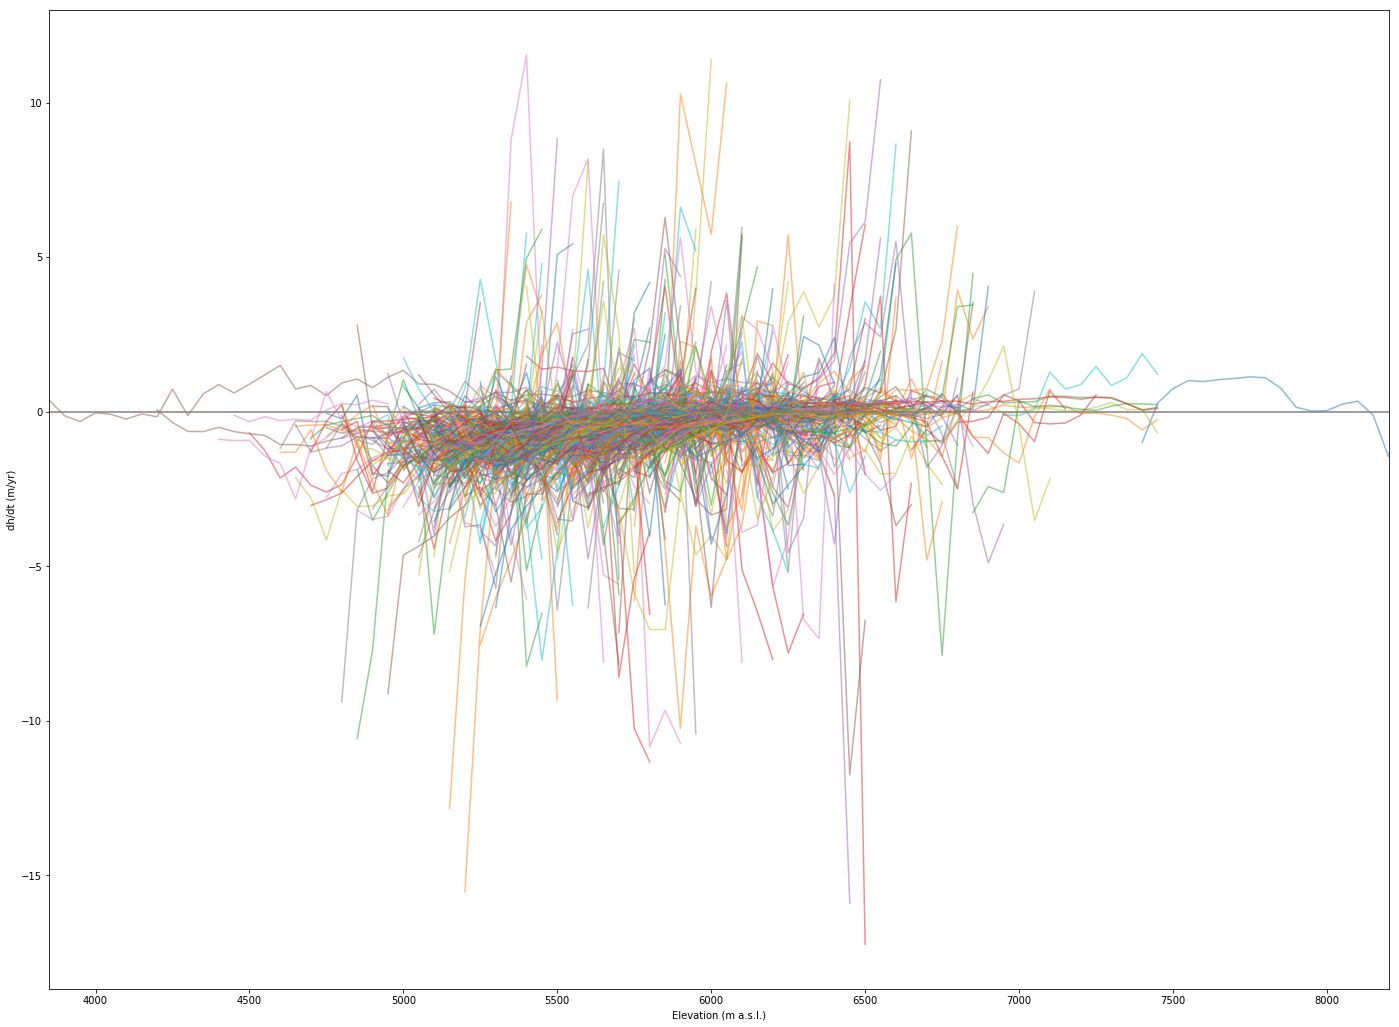

In [25]:
#ax=df1.plot(y='median',kind='line',)
#ax.set_xlim((3850, 8200))
#ax.set_ylim((-1.5,1.5))
#ax.axhline(y=0,color='r')
#ax.set_xlabel("Elevation (m a.s.l.)")

# Set the y-axis label
#ax.set_ylabel("dh/dt (m/yr)")
fig, ax = plt.subplots(figsize=(24,18))
#bp = p_df.groupby('class').plot(kind='kde', ax=ax)
bp=g.plot(y='median', ax=ax, legend=False,alpha=0.5)
ax.set_xlim((3850, 8200))
ax.axhline(y=0,color='grey')
ax.set_xlabel("Elevation (m a.s.l.)")
ax.set_ylabel("dh/dt (m/yr)")

In [ ]:
#df.plot()

In [ ]:
#geolib.clip_raster_by_shp('B-tile-0.tif','mummy.shp')

#importing rasters after warping them through GDAL Warp as masked arrays to common extent
fn1='B-tile-0_shpclip.tif' #DEM Clipped to glacier extent
fn2='WV-Carto.tif' #Elevation Difference Clipped to Glacier extent
ds_list=warplib.memwarp_multi_fn([fn1,fn2],res='max',extent='intersection',t_srs='first', r='cubic')
A=iolib.ds_getma(ds_list[0])
dh=iolib.ds_getma(ds_list[1])
comm